In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
#import sndisplay as sn
import uproot as uproot
import pandas as pd
from matplotlib import cycler, patches

Welcome to JupyROOT 6.22/00


 - side or corner cells always starting earlier with precocious HV
(different field condition with neighbor cells being powered or not)

 - DATA vs current drift model implemented in Falaise ... not bad !
→ good starting point to build a data driven drift model RADIUS=f(R0)
Indication of tiny dependancy of anodic drift vs HV

In [202]:
RUN608 = ROOT.TFile.Open("snemo_run-608_red.root")

In [203]:
RUN608.ls()

TFile**		snemo_run-608_red.root	
 TFile*		snemo_run-608_red.root	
  KEY: TTree	RED;1	SuperNEMO RED data


In [207]:
tree = RUN608.RED

In [208]:
branches = tree.GetListOfBranches()
#print([branch.GetName() for branch in branches])

In [210]:
np.shape(tracker_cell_row_id)

(30,)

In [236]:
#for one event, there are ten entries, and these are filled with t1, t2, possibly t3 which represent times
len(tracker_anode_R0_ticks)
a = np.array(tracker_anode_R0_ticks)#*t_tdc2sec

In [237]:
a[:,0]

array([           591187508,            591187304,            591187398,
                  591187501,            591187370,            591187300,
                  591187322,            591187480,            591188850,
                  591187311,            591187319,            591187667,
                  591187376, -9223372036854775808,            591187757,
       -9223372036854775808,            591187302, -9223372036854775808,
       -9223372036854775808,            591187496])

In [219]:
from itertools import compress

In [218]:
calo = [1182374620, 1182374620]
HT_flag = [False, True]
calo[HT_flag]

TypeError: list indices must be integers or slices, not list

In [222]:
list(compress(calo, HT_flag))

[1182374620]

In [ ]:
def unpack(tree,event):
        xs = []
        ys = []
        ts = []
        errts = []
        for i in event:
            run_id = event.run_id
            event_id = event.event_id
            nb_tracker_hits = event.nb_tracker_hits #                                     # int Number of t
            tracker_anode_R0_ticks = [list(event.tracker_anode_R0_ticks)[i*MAX_GG_TIMES:MAX_GG_TIMES*(i+1)] 
                                      for i in range(nb_tracker_hits)]                 # list(int) Anode time LSB: 12.5 ns
            #print(np.shape(tracker_anode_R0_ticks))
            calo_ticks = list(event.calo_ticks)                                 # list(int) Calo TDC (6.25ns)
            calo_ht = list(event.calo_ht)
            calo_times=np.array(list(compress(calo_ticks, HT_flag)))
            xs.append(drift_times.xs)
            ys.append(drift_times.ys)
            ts.append(drift_times.dtime)
            errts.append(drift_times.errdtime)
        return xs, ys, ts, errts

In [ ]:
class Cell:
    def __init__(self, run):
        tree = run.RED
        unpacked_region = unpack(tree)
        self.x = unpacked_region[0]
        self.y = unpacked_region[1]
        self.t = unpacked_region[2]
        self.errt = unpacked_region[3]
        self.r = np.sqrt(np.array(unpacked_region[0])**2 + np.array(unpacked_region[1])**2)

In [354]:
i=0
j=0
c_tdc2sec = 0.625E-08
t_tdc2sec = 1.25E-08
g=[]
config=[]
for event in tree:
    run_id = event.run_id
    event_id = event.event_id
    nb_tracker_hits = event.nb_tracker_hits #                                     # int Number of t
    tracker_anode_R0_ticks = [list(event.tracker_anode_R0_ticks)[i*MAX_GG_TIMES:MAX_GG_TIMES*(i+1)] 
                              for i in range(nb_tracker_hits)]                 # list(int) Anode time LSB: 12.5 ns
    #print(np.shape(tracker_anode_R0_ticks))
    calo_ticks = list(event.calo_ticks)                                 # list(int) Calo TDC (6.25ns)
    calo_ht = list(event.calo_ht)
    calo_times=np.array(list(compress(calo_ticks, HT_flag)))
    tracker_cell_side_id = list(event.tracker_cell_side_id)                     # list(int) TR side (1: French, 0: Italian)
    tracker_cell_row_id = list(event.tracker_cell_row_id)                       # list(int) TR row (0-112)
    tracker_cell_layer_id = list(event.tracker_cell_layer_id)
    
    config = [tracker_cell_side_id,tracker_cell_row_id,tracker_cell_layer_id]# for i in range(nb_tracker_hits)]
    #for i_cell in range(nb_tracker_hits):
        #cell_config = [tracker_cell_side_id[i_cell],tracker_cell_row_id[i_cell],tracker_cell_layer_id[i_cell]]

    print('run',run_id,'event',event_id)

    if len(calo_times)<1:
        print('NO HT FLAG')
        g.append([event_id,'no ht flag'])
        continue
    elif len(calo_times)>1:
        print('MORE THAN ONE HT FLAG')
        print(calo_times)
        print('make a choice here')
        g.append([event_id,'more than one calo hit'])

        j+=1
        continue
    elif len(tracker_anode_R0_ticks)<1:
        print('NO ANODE DATA')
        g.append([event_id,'no anode data'])

        continue
    a = np.array(tracker_anode_R0_ticks)
    
    #for i in range(nb_tracker_hits):
        #config.append([tracker_cell_side_id[i], tracker_cell_row_id[i], tracker_cell_layer_id[i]])
    #print(a[:,0]*t_tdc2sec - calo_times*c_tdc2sec)
    #print('anode:',tracker_anode_R0_ticks)
    #print('calo:',calo_ticks)
    #if len(a[:,0]) > 20:
    print(a[:,0]*t_tdc2sec - calo_times*c_tdc2sec)
    #print(len(calo_times))
    g.append([('event no. %s'%event_id), a[:,0]*t_tdc2sec - calo_times*c_tdc2sec, 
             config])

    #print(tracker_anode_R0_ticks[0]-calo_times)
    
    i+=1
    #for i in range(nb_tracker_hits):
        #print(np.count_nonzero(tracker_anode_R0_ticks[i]))
print(j)

run 608 event 0
[ 2.47500000e-06 -7.50000000e-08  1.10000000e-06  2.38750000e-06
  7.50000000e-07 -1.25000000e-07  1.50000000e-07  2.12500000e-06
  1.92500000e-05  1.25000001e-08  1.12500000e-07  4.46250000e-06
  8.25000000e-07 -1.15292150e+11  5.58750000e-06 -1.15292150e+11
 -1.00000000e-07 -1.15292150e+11 -1.15292150e+11  2.32500000e-06]
run 608 event 1
[ 9.06249999e-07  1.44375000e-06  7.81250000e-07  3.56875000e-06
 -6.25000052e-09  8.49375000e-06  1.87499998e-08  6.13125000e-06
  7.31249999e-07  4.04375000e-06  4.43749999e-07  3.43125000e-06
  2.81249999e-07  8.55625000e-06  2.07312500e-05  5.93749999e-07
 -1.15292150e+11  1.68750000e-07  2.35625000e-06 -1.15292150e+11
 -1.15292150e+11 -1.15292150e+11 -1.15292150e+11 -1.15292150e+11
 -1.15292150e+11 -1.15292150e+11 -1.15292150e+11 -1.15292150e+11
 -1.15292150e+11 -1.15292150e+11 -1.15292150e+11]
run 608 event 2
[ 1.49375000e-06 -6.25000141e-09  6.68749999e-07  3.71875000e-06
  2.33125000e-06  6.24999963e-09  7.18750000e-07  2.1687

In [349]:
len(g[0][1]),np.shape(g[0][2])

(20, (1, 1, 3, 20))

In [357]:
g[3]

['event no. 3',
 array([-6.24999998e-08,  1.62500000e-06,  1.10000000e-06,  3.31250000e-06,
         1.75000000e-07, -1.12499999e-07,  6.23750000e-06,  1.10000000e-06,
         1.45000000e-06,  9.93750000e-06,  1.26250000e-06,  2.80000000e-06,
         1.93750000e-06,  2.86250000e-06,  3.28750000e-06,  1.97500000e-06,
         2.48750000e-06,  2.21250000e-06,  2.33750000e-06]),
 [[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
  [10, 10, 9, 7, 8, 9, 10, 11, 11, 9, 9, 8, 11, 11, 11, 11, 11, 11, 11],
  [0, 1, 4, 8, 7, 3, 0, 8, 7, 5, 2, 8, 6, 1, 0, 3, 2, 4, 5]]]

In [359]:
g[6157]

['event no. 6157',
 array([ 1.93750020e-06,  1.38750011e-06,  3.53750011e-06, -1.15292153e+11,
         1.98750013e-06,  3.01250020e-06, -1.15292153e+11, -1.15292153e+11,
         1.66249993e-06,  2.83750023e-06,  1.04125002e-05,  3.01250020e-06,
         1.95000030e-06,  2.27500004e-06,  4.33750029e-06,  2.60000024e-06,
         2.75000002e-06, -1.15292153e+11,  2.58750015e-06,  3.80000029e-06,
         2.26249995e-06, -1.15292153e+11,  5.30000034e-06,  2.32499997e-06,
         1.16250021e-06]),
 [[1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1],
  [7, 7, 7, 6, 7, 7, 8, 7, 7, 7, 6, 6, 6, 6, 7, 7, 7, 6, 6, 7, 7, 6, 6, 7, 7],
  [3, 8, 8, 0, 0, 1, 4, 1, 2, 7, 8, 2, 4, 5, 6, 5, 6, 3, 3, 2, 4, 1, 6, 7, 0]]]

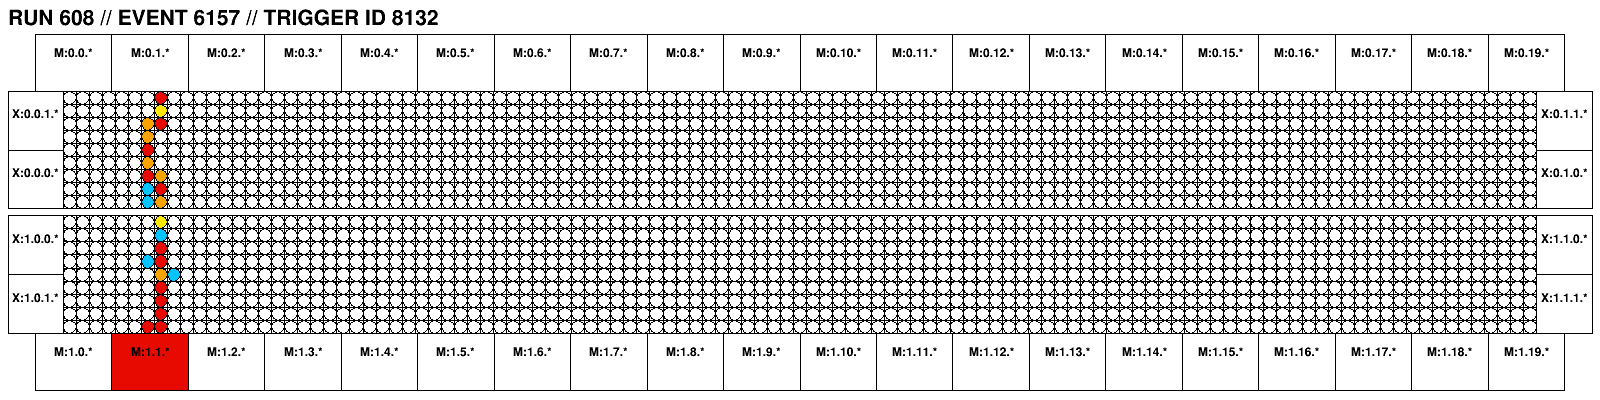

In [367]:
#convert these drift times to radii
def func(t,a,b):
    
    """ A function that calculates distance from time"""
    power = (1/(1-b))
    
    return (t/a)**power

In [373]:
#from sim
a_850 = [7.667806974115485e-07, 8.050174394921506e-07, 8.282262761081532e-07] #TLL, TLR, CTL,
a_880 = [7.919722864076415e-07, 8.352046672882399e-07, 8.561280441598992e-07]
a_910 = [8.165303193677484e-07, 8.555670844313254e-07, 8.816779854480169e-07]

In [374]:
a2_850 = [5.040765825385896e-07, 3.3410328858284424e-07, 4.0197946378891274e-07]
a2_880 = [4.936923175349556e-07, 3.385664297966756e-07, 3.965751068557517e-07]
a2_910 = [5.08159670444221e-07, 3.346803886792308e-07, 4.522209016344719e-07]

In [375]:
#from sim
b_850 = [-0.8723131619062534, -0.8965351358544076, -0.9074662224626731,] #TLL, TLR, CTL,
b_880 = [ -0.8674544901543968, -0.9159476345440333, -0.9141298619832084,]
b_910 = [-0.8773125810867367, -0.8949585119296312, -0.9177618436101517]

In [376]:
#from sim
b2_850 = [-1.4251969110069622, -2.0371979996169487, -1.9549484632589416] #TLL, TLR, CTL,
b2_880 = [-1.4789533479159933, -2.066336243954897, -1.9886408137292864]
b2_910 = [ -1.4801813501702243, -2.106005283774911, -1.8983590040931866]

a,b depend on pressure, configuration and wether particle lies in cell symmetry or not

In [387]:
len(drift_list)

26

In [388]:
event=6309
#a,b = 
drift_list = np.array(g[event][1])
new = []
cell_config = 2 #0 for corner, 1 for edge, 2 for centre
for i in range(len(drift_list)):
    if drift_list[i]>0: #ie if time is physical
        if drift_list[i] > 4e-6:
            a = a2_850[2]
            b = b2_850[2]
            x = func(drift_list[i],a,b)
        elif drift_list[i] < 4e-6:
            a = a_850[2]
            b = b_850[2]
            x = func(drift_list[i],a,b)
        new.append(x)
new

[0.2838936515391403,
 0.5999059663560806,
 1.1741614960380964,
 1.6133687601264337,
 1.8580429993700054,
 2.2033819336074325,
 1.4967603489145533,
 1.4857488829610705,
 2.656641390668333,
 1.0596450238296413,
 0.37107429559039207,
 1.3948326648137885,
 0.39008690593537143,
 2.8014862049902933,
 1.4967603489145533,
 0.22952930835995772,
 1.7227846204455637,
 1.9246073137627515,
 2.8538947578925953,
 1.463500880159053]

In [390]:
len(new)

20

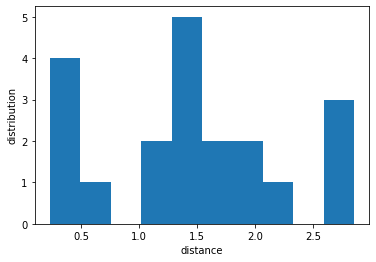

In [393]:
plt.hist(new)
plt.xlabel('distance')
plt.ylabel('distribution');

In [38]:
292808582739*t_tdc2sec

3660.1072842374997

In [56]:
nb_tracker_hits

27

In [61]:
tracker_anode_R0_ticks[0]

[292808583318, -9223372036854775808, -9223372036854775808, 0, 0, 0, 0, 0, 0, 0]

In [63]:
tracker_anode_R0_ticks[0][0] * t_tdc2sec

3660.107291475

In [184]:
i = 0
data = {}
c_tdc2sec = 0.625E-08
t_tdc2sec = 1.25E-08
MAX_GG_TIMES = 10
for event in tree:
    run_id = event.run_id
    event_id = event.event_id
    
    #CALO
    n_calo_hits = int(event.nb_calo_hits)                               # int Number of calorimeter hits
    calo_om_side_id = list(event.calo_om_side_id)                       # list(int) List of OM sides (1: French, 0: Italian)
    calo_om_wall_id = list(event.calo_om_wall_id)                       # list(int) List of OM walls (0,1) see url:https://nemo.lpc-caen.in2p3.fr/wiki/NEMO/SuperNEMO/Calorimeter
    calo_om_column_id = list(event.calo_om_column_id)                   # list(int) List of OM columns
    calo_om_row_id = list(event.calo_om_row_id)                         # list(int) List of OM rows
    calo_ticks = list(event.calo_ticks)                                 # list(int) Calo TDC (6.25ns)
    calo_lto = list(event.calo_lto)                                     # list(bool) Calo low threshold flag
    calo_ht = list(event.calo_ht)                                       # list(bool) Calo high threshold flag
   
    #TRACKER
    nb_tracker_hits = event.nb_tracker_hits                                     # int Number of tracker cells that have at least one hit
    tracker_cell_side_id = list(event.tracker_cell_side_id)                     # list(int) TR side (1: French, 0: Italian)
    tracker_cell_row_id = list(event.tracker_cell_row_id)                       # list(int) TR row (0-112)
    tracker_cell_layer_id = list(event.tracker_cell_layer_id)                   # list(int) TR layer (0-8)
    tracker_anode_R0_ticks = [list(event.tracker_anode_R0_ticks)[i*MAX_GG_TIMES:MAX_GG_TIMES*(i+1)] for i in range(nb_tracker_hits)]                 # list(int) Anode time LSB: 12.5 ns
    

    if len(list(event.tracker_cell_side_id)) > 50:
        continue
    data[event_id] = {}
    #data[event_id]['flag'] = calo_ht
    for i_cell in range(nb_tracker_hits):
        cell = tracker_cell_side_id[i_cell] * 113 * 9 + tracker_cell_row_id[i_cell] * 9 + tracker_cell_layer_id[i_cell]
        cell_config = [tracker_cell_side_id[i_cell],tracker_cell_row_id[i_cell],tracker_cell_layer_id[i_cell]]
        data[event_id][cell] = {}
        data[event_id][cell]['config'] = cell_config
        data[event_id][cell]['flag'] = calo_ht
        data[event_id][cell]['n_calo_hits'] = n_calo_hits

        #data[event_id][cell][tracker_cell_side_id[i_cell]][tracker_cell_row_id[i_cell]] = {}
        #data[event_id][cell][tracker_cell_side_id[i_cell]][tracker_cell_row_id[i_cell]][tracker_cell_layer_id[i_cell]] = {}
        
        rs = [np.asarray(tracker_anode_R0_ticks[i_cell])*t_tdc2sec, np.array(calo_ticks)*c_tdc2sec]
        #tracker_anode_R1_ticks[i_cell], tracker_anode_R2_ticks[i_cell],
        #tracker_anode_R3_ticks[i_cell], tracker_anode_R4_ticks[i_cell], 
        #tracker_bottom_cathode_R5_ticks[i_cell], tracker_top_cathode_R6_ticks[i_cell]]
        #for index, r in enumerate(rs):
        #data[event_id][cell][f'r{index}'] = r#*t_tdc2sec
        data[event_id][cell]['anode'] = np.asarray(tracker_anode_R0_ticks[i_cell])*t_tdc2sec
        data[event_id][cell]['calo'] = np.array(calo_ticks)*c_tdc2sec
        data[event_id][cell]['drift'] = rs[0][0] - rs[1]
        

            #data[event_id][tracker_cell_row_id[i_cell]][tracker_cell_layer_id[i_cell]][f'r{index}'] = r#*t_tdc2sec
    i +=1
    if i == 10:
        break

In [185]:
data#['drift']#'config']

{0: {45: {'config': [0, 5, 0],
   'flag': [0, 1],
   'n_calo_hits': 2,
   'anode': array([7.38984385, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]),
   'calo': array([7.38984137, 7.38984137]),
   'drift': array([2.475e-06, 2.475e-06])},
  64: {'config': [0, 7, 1],
   'flag': [0, 1],
   'n_calo_hits': 2,
   'anode': array([7.3898413, 0.       , 0.       , 0.       , 0.       , 0.       ,
          0.       , 0.       , 0.       , 0.       ]),
   'calo': array([7.38984137, 7.38984137]),
   'drift': array([-7.5e-08, -7.5e-08])},
  55: {'config': [0, 6, 1],
   'flag': [0, 1],
   'n_calo_hits': 2,
   'anode': array([7.38984248, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]),
   'calo': array([7.38984137, 7.38984137]),
   'drift': array([1.1e-06, 1.1e-06])},
  73: {'config': [0, 8, 1],
   'flag': [0, 1],
   'n_calo_hits': 2,
   'anode': array([7.389

In [164]:
i = 0
data = {}
c_tdc2sec = 0.625E-08
t_tdc2sec = 1.25E-08
MAX_GG_TIMES = 10
for event in tree:
    run_id = event.run_id
    event_id = event.event_id
    
    ###CALO
    n_calo_hits = int(event.nb_calo_hits)                               # int Number of calorimeter hits
    calo_om_side_id = list(event.calo_om_side_id)                       # list(int) List of OM sides (1: French, 0: Italian)
    calo_om_wall_id = list(event.calo_om_wall_id)                       # list(int) List of OM walls (0,1) see url:https://nemo.lpc-caen.in2p3.fr/wiki/NEMO/SuperNEMO/Calorimeter
    calo_om_column_id = list(event.calo_om_column_id)                   # list(int) List of OM columns
    calo_om_row_id = list(event.calo_om_row_id)                         # list(int) List of OM rows
    calo_ticks = list(event.calo_ticks)                                 # list(int) Calo TDC (6.25ns)
    calo_lto = list(event.calo_lto)                                     # list(bool) Calo low threshold flag
    calo_ht = list(event.calo_ht)                                       # list(bool) Calo high threshold flag
    
    ###TRACKER
    nb_tracker_hits = event.nb_tracker_hits                                     # int Number of tracker cells that have at least one hit
    tracker_cell_side_id = list(event.tracker_cell_side_id)                     # list(int) TR side (1: French, 0: Italian)
    tracker_cell_row_id = list(event.tracker_cell_row_id)                       # list(int) TR row (0-112)
    tracker_cell_layer_id = list(event.tracker_cell_layer_id)                   # list(int) TR layer (0-8)
    tracker_anode_R0_ticks = [list(event.tracker_anode_R0_ticks)[i*MAX_GG_TIMES:MAX_GG_TIMES*(i+1)] for i in range(nb_tracker_hits)]                 # list(int) Anode time LSB: 12.5 ns
    

    if len(list(event.tracker_cell_side_id)) > 50:
        continue
    data[event_id] = {}
    for i_cell in range(nb_tracker_hits):
        cell = tracker_cell_side_id[i_cell] * 113 * 9 + tracker_cell_row_id[i_cell] * 9 + tracker_cell_layer_id[i_cell]
        cell_config = np.array([tracker_cell_side_id[i_cell],tracker_cell_row_id[i_cell],tracker_cell_layer_id[i_cell]])
        data[event_id][cell] = {}
        data[event_id][cell][tracker_cell_side_id[i_cell]] = {}
        data[event_id][cell][tracker_cell_side_id[i_cell]][tracker_cell_row_id[i_cell]] = {}
        data[event_id][cell][tracker_cell_side_id[i_cell]][tracker_cell_row_id[i_cell]][tracker_cell_layer_id[i_cell]] = {}
        
        rs = np.array([tracker_anode_R0_ticks[i_cell]])*t_tdc2sec, np.array(calo_ticks)*c_tdc2sec
        #tracker_anode_R1_ticks[i_cell], tracker_anode_R2_ticks[i_cell],
        #tracker_anode_R3_ticks[i_cell], tracker_anode_R4_ticks[i_cell], 
        #tracker_bottom_cathode_R5_ticks[i_cell], tracker_top_cathode_R6_ticks[i_cell]]
        for index, r in enumerate(rs):
            data[event_id][cell][tracker_cell_side_id[i_cell]][tracker_cell_row_id[i_cell]][tracker_cell_layer_id[i_cell]][f'r{index}'] = r#*t_tdc2sec

            #data[event_id][tracker_cell_row_id[i_cell]][tracker_cell_layer_id[i_cell]][f'r{index}'] = r#*t_tdc2sec
    i +=1
    if i == 10:
        break

In [165]:
data

{0: {45: {0: {5: {0: {'r0': array([[7.38984385, 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ]]),
      'r1': array([7.38984137, 7.38984137])}}}},
  64: {0: {7: {1: {'r0': array([[7.3898413, 0.       , 0.       , 0.       , 0.       , 0.       ,
              0.       , 0.       , 0.       , 0.       ]]),
      'r1': array([7.38984137, 7.38984137])}}}},
  55: {0: {6: {1: {'r0': array([[7.38984248, 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ]]),
      'r1': array([7.38984137, 7.38984137])}}}},
  73: {0: {8: {1: {'r0': array([[7.38984376, 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ]]),
      'r1': array([7.38984137, 7.38984137])}}}},
  36: {0: {4: {0: {'r0': array([[7.38984212, 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 

In [77]:
event_no = 2
cell_no = 1086
data[event_no][cell_no]['r0'][0][0] - data[event_no][cell_no]['r1'][0]

-6.2500014053057384e-09

In [70]:
data[0][101]['r0']#[0][0] - data[0][101]['r1'][0]

array([[7.38984584, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [27]:
#event 0
(data[0])
print('cell id     anode timestamps')
data[0]

cell id     anode timestamps


{45: {'r0': array([7.38984385, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ])},
 64: {'r0': array([7.3898413, 0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       ])},
 55: {'r0': array([7.38984248, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ])},
 73: {'r0': array([7.38984376, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ])},
 36: {'r0': array([7.38984212, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ])},
 18: {'r0': array([7.38984125, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ])},
 0: {'r0': array([7.38984152, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.   

In [ ]:
#nb_tracker_hits - integer number of cells that have at least one hit


In [9]:
Ntuple1 = uproot.open("snemo_run-608_red.root" + ":RED")
Ntuple1.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run_id               | int32_t                  | AsDtype('>i4')
event_id             | int32_t                  | AsDtype('>i4')
event_clock          | int16_t                  | AsDtype('>i2')
event_ticks          | int64_t                  | AsDtype('>i8')
nb_calo_hits         | uint32_t                 | AsDtype('>u4')
calo_hit_id          | int32_t[]                | AsJagged(AsDtype('>i4'))
calo_om_side_id      | int16_t[]                | AsJagged(AsDtype('>i2'))
calo_om_wall_id      | int16_t[]                | AsJagged(AsDtype('>i2'))
calo_om_column_id    | int16_t[]                | AsJagged(AsDtype('>i2'))
calo_om_row_id       | int16_t[]                | AsJagged(AsDtype('>i2'))
calo_om_ref_id       | int16_t[]                | AsJagged(AsDtype('>i2'))
calo_clock           | int16_t[]                | AsJagged(AsDt

In [10]:
ntp1df = Ntuple1.arrays(['event_id', 'tracker_anode_R0_ticks'], library='np')
ntp1df

{'event_id': array([   0,    1,    2, ..., 7550, 7551, 7552], dtype=int32),
 'tracker_anode_R0_ticks': array([array([[           591187508,                    0,                    0,
                            0,                    0,                    0,
                            0,                    0,                    0,
                            0],
        [           591187304,                    0,                    0,
                            0,                    0,                    0,
                            0,                    0,                    0,
                            0],
        [           591187398,                    0,                    0,
                            0,                    0,                    0,
                            0,                    0,                    0,
                            0],
        [           591187501,                    0,                    0,
                            0,               

In [11]:
calo_events = Ntuple1.arrays(["event_id", 'calo_om_side_id', 'calo_om_wall_id', 'calo_om_column_id', 'calo_om_row_id'], library='pd')
# calo_events = calo_events.set_index("event_id")
calo_events

event_id  calo_om_side_id  calo_om_wall_id  calo_om_column_id  \
entry subentry                                                                  
0     0                0                0                0                  0   
      1                0                0                0                  0   
1     0                1                1               -1                  0   
      1                1                1               -1                  0   
2     0                2                0               -1                  2   
...                  ...              ...              ...                ...   
7550  1             7550                0                0                  0   
7551  0             7551                0               -1                  1   
      1             7551                0               -1                  1   
7552  0             7552                0               -1                  1   
      1             7552                0               -1                  1   

                calo_om_row_id  
entry subentry                  
0     0                      8  
      1                      9  
1     0                      4  
      1                      5  
2     0                      6  
...                        ...  
7550  1                     13  
7551  0                      6  
      1                      7  
7552  0                      6  
      1                      7  

[13758 rows x 5 columns]

In [13]:
print(calo_events["calo_om_side_id"][0])
#print(calo_events["calo_om_side_id"][0][2])

subentry
0    0
1    0
Name: calo_om_side_id, dtype: int16


In [15]:
#where "tracker_anode_R0_ticks[nb_tracker_hits][10]/L" is what you want to retrieve.    
#"nb_tracker_hits" is the number of hits in the event 
#and [10] is a maximum number of times the same Geiger cell can be hit in the same event.

In [18]:
ntp1df = Ntuple1.arrays(['event_id', 'tracker_anode_R0_ticks'], library='np')


In [21]:
tracker_anode_R0_ticks

[[1071206843, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206603, -9223372036854775808, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071208009, -9223372036854775808, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206893, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [-9223372036854775808, -9223372036854775808, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206693, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206592, -9223372036854775808, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206662, -9223372036854775808, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206751, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206790, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206592, -9223372036854775808, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206662, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206795, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071208807, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206914, -9223372036854775808, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206850, -9223372036854775808, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071206625, -9223372036854775808, 0, 0, 0, 0, 0, 0, 0, 0],
 [-9223372036854775808, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1071207006, -9223372036854775808, 0, 0, 0, 0, 0, 0,

In [25]:
nb_tracker_hits

30